## Algorithm Chains and Pipelines 

As an example of the importance of chaining models, we noticed that we can greatly
improve the performance of a kernel SVM on the cancer dataset by using the Min
MaxScaler for preprocessing. Here’s code for splitting the data, computing the minimum
and maximum, scaling the data, and training the SVM:

In [1]:
# import modules
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline 
import warnings
warnings.filterwarnings('ignore')   

In [2]:
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, random_state=0) 

In [3]:
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train) 

In [4]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

In [5]:
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [6]:
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


Now let’s say we want to find better parameters for SVC using GridSearchCV,

In [7]:
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best test set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best test set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator.

The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn. The most common use case of the Pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier.

## Building Pipelines 

Let’s look at how we can use the Pipeline class to express the workflow for training
an SVM after scaling the data with MinMaxScaler (for now without the grid search).

In [11]:
# create a pipeline 
pipe = Pipeline([('scaler',MinMaxScaler()),('svm',SVC())])

Here, we created two steps: the first, called "scaler", is an instance of MinMaxScaler, and the second, called "svm", is an instance of SVC. Now, we can fit the pipeline, like
any other scikit-learn estimator:

In [12]:
# train the model 
pipe.fit(X_train, y_train) 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVM with the scaled data. To evaluate on
the test data, we simply call pipe.score:

In [13]:
# find the score in the test set  
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


Calling the score method on the pipeline first transforms the test data using the
scaler, and then calls the score method on the SVM using the scaled test data. As you
can see, the result is identical to the one we got from the code at the beginning

Using the pipeline, we reduced the
code needed for our “preprocessing + classification” process.

## Using Pipelines in Grid Searches 

Using a pipeline in a grid search works the same way as using any other estimator. We
define a parameter grid to search over, and construct a GridSearchCV from the pipeline
and the parameter grid. 

When specifying the parameter grid, there is a slight
change, though. We need to specify for each parameter which step of the pipeline it
belongs to.

Both parameters that we want to adjust, C and gamma, are parameters of
SVC, the second step. We gave this step the name "svm". The syntax to define a parameter
grid for a pipeline is to specify for each parameter the step name, followed by __
(a double underscore), followed by the parameter name.

In [14]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
               'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [15]:
# train with grid search 
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_)) 

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In contrast to the grid search we did before, now for each split in the cross-validation,
the MinMaxScaler is refit with only the training splits and no information is leaked
from the test split into the parameter search.

## The General Pipeline Interface 

The Pipeline class is not restricted to preprocessing and classification, but can in
fact join any number of estimators together. 

For example, you could build a pipeline
containing feature extraction, feature selection, scaling, and classification, for a total
of four steps. 

The only requirement for estimators in a pipeline is that all but the last step need to
have a transform method, so they can produce a new representation of the data that
can be used in the next step. 

## Convenient Pipeline Creation with make_pipeline 

Creating a pipeline using the syntax described earlier is sometimes a bit cumbersome,
and we often don’t need user-specified names for each step. There is a convenience
function, **make_pipeline**, that will create a pipeline for us and automatically name
each step based on its class. The syntax for make_pipeline is as follows: 

In [17]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

The pipeline objects pipe_long and pipe_short do exactly the same thing, but
pipe_short has steps that were automatically named. We can see the names of the
steps by looking at the steps attribute: 

In [18]:
# show pipeline stesps
print(pipe_short.steps) 

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


The steps are named minmaxscaler and svc. In general, the step names are just lowercase
versions of the class names. If multiple steps have the same class, a number is
appended:

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps)) 

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


As you can see, the first StandardScaler step was named standardscaler-1 and the
second standardscaler-2. 

## Accessing Step Attributes 

Often you will want to inspect attributes of one of the steps of the pipeline—say, the
coefficients of a linear model or the components extracted by PCA. The easiest way to
access the steps in a pipeline is via the named_steps attribute, which is a dictionary
from the step names to the estimators: 

In [20]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape)) 


components.shape: (2, 30)


## Accessing Attributes in a Grid-Searched Pipeline 

one of the main reasons to use pipelines is for doing grid searches. A common task is to access some of the steps of a pipeline inside
a grid search.

In [21]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

#create pipeline with standardscaler and logistic regression algorithm 
pipe = make_pipeline(StandardScaler(), LogisticRegression()) 

Next, we create a parameter grid.The regularization parameter to tune for LogisticRegression is the parameter C. We use a logarithmic
grid for this parameter, searching between 0.01 and 100.or

In [22]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]} 

In [23]:
# As usual, we split the cancer dataset into training and test sets, and fit a grid search:

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
# access the coefficients of the best LogisticRegression model that was found by GridSearchCV
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


To access the logisticregression step, we can use the
named_steps attribute of the pipeline, as explained earlier:

In [25]:
print("Logistic regression step:\n{}".format( grid.best_estimator_.named_steps["logisticregression"])) 

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Now that we have the trained LogisticRegression instance, we can access the coefficients
(weights) associated with each input feature:

In [27]:
print("Logistic regression coefficients:\n{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_)) 

Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


## Grid-Searching Preprocessing Steps and Model Parameters

Using pipelines, we can encapsulate all the processing steps in our machine learning
workflow in a single scikit-learn estimator. Another benefit of doing this is that we
can now adjust the parameters of the preprocessing using the outcome of a supervised
task like regression or classification.

In [28]:
# import boston dataset 
from sklearn.datasets import load_boston

#load the dataset 
boston = load_boston()

# split the boston dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
random_state=0)

In [31]:
# import polynoialfeatures  and ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge 

# create a pipeline
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge()) 

How do we know which degrees of polynomials to choose, or whether to choose any
polynomials or interactions at all? Ideally we want to select the degree parameter
based on the outcome of the classification. Using our pipeline, we can search over the
degree parameter together with the parameter alpha of Ridge.

In [32]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]} 

In [33]:
# train the grid search again 
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We can visualize the outcome of the cross-validation using a heat map

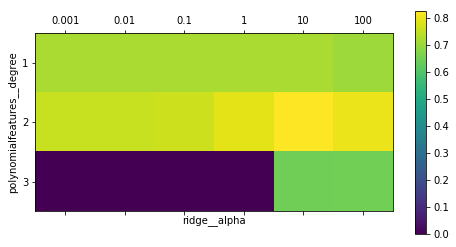

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")

plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree'])

plt.colorbar()


Looking at the results produced by the cross-validation, we can see that using polynomials
of degree two helps

In [36]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [39]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))  

Test-set score: 0.77


Searching over preprocessing parameters together with model parameters is a very
powerful strategy. However, keep in mind that GridSearchCV tries all possible combinations
of the specified parameters. Therefore, adding more parameters to your grid
exponentially increases the number of models that need to be built.

## Grid-Searching Which Model To Use 

You can even go further in combining GridSearchCV and Pipeline: it is also possible
to search over the actual steps being performed in the pipeline (say whether to use
StandardScaler or MinMaxScaler). This leads to an even bigger search space and
should be considered carefully.

We want
two steps, one for the preprocessing and then a classifier. We can instantiate this
using SVC and StandardScaler:

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())]) 

Now we can define the parameter_grid to search over. We want the classifier to
be either RandomForestClassifier or SVC. 

To assign an estimator
to a step, we use the name of the step as the parameter name. When we wanted to
skip a step in the pipeline (for example, because we don’t need preprocessing for the
RandomForest), we can set that step to None:

In [42]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
{'classifier': [RandomForestClassifier(n_estimators=100)],
'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}] 

Now we can instantiate and run the grid search as usual, here on the cancer dataset:

In [44]:
# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

In [45]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'classifier': [SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)], 'preprocessing': [StandardScaler(copy=True, with...=0,
            warm_start=False)], 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


The outcome of the grid search is that SVC with StandardScaler preprocessing, C=10,
and gamma=0.01 gave the best result

**NOTE:** Be careful not to overcomplicate your processes, and make sure to
evaluate whether every component you are including in your model is necessary.

## Resources 

Book of A. C. Muller and S. Guido - Introduction to Machine Learning with Python - 2017-ilovepdf-compressed - Chapter 6 